In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm

In [3]:
import sys
sys.path.insert(0, 'code')
from models import *
from v13_deeplab import *

In [4]:
FMT_VALTRAIN_IMAGELIST_PATH_ALL = 'data/working/images/v5/all_valtrain_ImageId.csv'
FMT_VALTRAIN_IM_STORE_ALL = 'data/working/images/v12/all_valtrain_im.h5'
FMT_VALTRAIN_MUL_STORE_ALL = 'data/working/images/v12/all_valtrain_mul.h5'

In [5]:
gpu = 0
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
bs = 25
num_slice = 9
STRIDE_SZ = 197
PATH = 'data/'

BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

## Preprocessing

In [1]:
for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
    !python code/v5_im.py preproc_train {train_path}

2018-04-09 21:10:10,972 INFO Preproc for training on AOI_2_Vegas
2018-04-09 21:10:10,972 INFO Generate IMAGELIST csv ... skip
2018-04-09 21:10:10,972 INFO Generate IMAGELIST csv ... skip
2018-04-09 21:10:10,973 INFO Generate band stats csv (MUL) ... skip
2018-04-09 21:10:10,973 INFO Generate MASK (valtrain)
2018-04-09 21:10:10,973 INFO prep_image_mask for AOI_2_Vegas
2018-04-09 21:10:12,033 INFO Prepare image container: data/working/images/v5/valtrain_AOI_2_Vegas_mask.h5
100%|███████████████████████████████████████| 2695/2695 [01:41<00:00, 26.64it/s]
2018-04-09 21:11:53,239 INFO Generate MASK (valtest)
2018-04-09 21:11:53,240 INFO prep_image_mask for AOI_2_Vegas
2018-04-09 21:11:53,812 INFO Prepare image container: data/working/images/v5/valtest_AOI_2_Vegas_mask.h5
100%|███████████████████████████████████████| 1156/1156 [00:41<00:00, 27.54it/s]
2018-04-09 21:12:35,839 INFO Generate MUL_STORE (valtrain)
2018-04-09 21:12:35,862 INFO prep_mul_image_store_train for 
2018-04-09 21:12:35,868

In [7]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
# area_id = directory_name_to_area_id(datapath)
# prefix = area_id_to_prefix(area_id)
# fn_train = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
# df_train = pd.read_csv(fn_train)

# df_train = df_train.iloc[0:100]
# # !cp {fn_train} {fn_train + '.bak'}
# df_train.to_csv(fn_train)


In [10]:
# area_id = directory_name_to_area_id(datapath)
# prefix = area_id_to_prefix(area_id)
# fn_train = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
# !cp {fn_train + '.bak'} {fn_train}

In [11]:
# # memory dataset
# def get_dataset(datapath):
#     area_id = directory_name_to_area_id(datapath)
#     prefix = area_id_to_prefix(area_id)
#     trn_x, trn_y = get_valtrain_data(area_id)
#     val_x, val_y = get_valtest_data(area_id)
    
#     trn_x = trn_x[:,:3]; trn_x = np.moveaxis(trn_x, 1, -1).astype('float')
#     trn_y = trn_y[:,:3]; trn_y = np.moveaxis(trn_y, 1, -1).astype('float')
#     trn_y = np.broadcast_to(trn_y, (trn_y.shape[0], 256, 256, 3))
    
#     val_x = val_x[:,:3]; val_x = np.moveaxis(val_x, 1, -1).astype('float')
#     val_y = val_y[:,:3]; val_y = np.moveaxis(val_y, 1, -1).astype('float')
#     val_y = np.broadcast_to(val_y, (val_y.shape[0], 256, 256, 3))
#     return (trn_x,trn_y), (val_x,val_y)


In [12]:
datapath = 'data/train/AOI_3_Paris_Train'

In [13]:
datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

In [14]:
# # get_im algorithm test
# cum_ns = np.array([2, 4, 6])
# i = 5
# idx_file = np.argmax(i + 1 <= cum_ns)
# if idx_file == 0:
#     idx_im = i
# else:
#     idx_im = i - cum_ns[idx_file - 1]

# print(idx_file, idx_im)

In [35]:
class H5Dataset(BaseDataset):
    def __init__(self, idxs, y, transform, datapaths=datapaths, is_rgb=True):
        area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
        self.prefixes = [area_id_to_prefix(area_id) for area_id in area_ids]
        self.is_rgb = is_rgb
        self.file_lists = [FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) for prefix in self.prefixes]
        self.x_h5_lists = [FMT_VALTRAIN_MUL_STORE.format(prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_MUL_STORE.format(prefix) for prefix in self.prefixes]
        self.y_h5_lists = [FMT_VALTRAIN_MASK_STORE.format(prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_MASK_STORE.format(prefix) for prefix in self.prefixes]
        self.idxs = idxs # idx of trn or val. 0 ... len-1. Generate by permutation
        if transform is not None:
            super().__init__(transform)
        self.ys = y
        
        # open all files
        self.x_h5_lists_open = [tb.open_file(o) for o in self.x_h5_lists]
        self.df_lists = [pd.read_csv(o) for o in self.file_lists]

        # choose next h5 after one is exhausted
        self.ns = []
        for file_list in self.file_lists:
            df = pd.read_csv(file_list)
            self.ns.append(df.shape[0])
        self.ns = np.array(self.ns) # number of pre-crop images
        self.cum_ns = np.cumsum(self.ns * num_slice)
        
    @staticmethod
    def load_y(datapaths=datapaths):
        dummy_dataset = H5Dataset(None, None, None, datapaths=datapaths)
            
        y = []
        print('Loading masks...')
        for idx_file, df_list in enumerate(dummy_dataset.df_lists):
            with tb.open_file(dummy_dataset.y_h5_lists[idx_file]) as f:
                ys = []
                for idx_im in tqdm.tqdm(range(dummy_dataset.ns[idx_file] * num_slice), total=dummy_dataset.ns[idx_file] * num_slice):
                    slice_pos = idx_im % num_slice
                    im = np.array(f.get_node('/' + df_list.iloc[idx_im // num_slice][0] + '_' + str(slice_pos)))
                    im = np.broadcast_to(im[...,None], (256, 256, 3))
                    ys.append(im.astype('float'))
            y += ys
        return np.array(y)

        
    def get_sz(self): return self.transform.sz
    
    def get_file_idx(self,i):
        idx_file = np.argmax(i + 1 <= self.cum_ns)
        if idx_file == 0:
            idx_im = i
        else:
            idx_im = i - self.cum_ns[idx_file - 1]
        return idx_file, idx_im
    
    def get_x(self, i):
        idx_file, idx_im = self.get_file_idx(i)
        h5_list_open = self.x_h5_lists_open
        f = h5_list_open[idx_file]
        df_list = self.df_lists[idx_file]
        slice_pos = idx_im % num_slice
        
        im = np.array(f.get_node('/' + df_list.iloc[idx_im // num_slice][0] + '_' + str(slice_pos)))
        if self.is_rgb:
            # Or other bands
            im = im[...,:3]
        return im.astype('float')
    
    def get_y(self, i):
        return self.ys[i]
        
    def get_c(self): return 1
        
    def get_n(self): return self.idxs.shape[0]

#     def resize_imgs(self, targ, new_path):
#         dest = resize_imgs(self.fnames, targ, self.path, new_path)
#         return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

    @staticmethod
    def get_ns(datapaths=datapaths):
        return H5Dataset(None, None, None, datapaths=datapaths).cum_ns[-1]

In [16]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model))
        return [c[:cut_base],
               c[cut_base:]]

In [17]:
def jaccard_coef(y_true, y_pred, thresh=0.5):
    
    smooth = 1e-12
    intersection = torch.sum(y_true * y_pred)
    sum_ = torch.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
    intersection = torch.sum(y_true * y_pred_pos)
    sum_ = torch.sum(y_true + y_pred_pos)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

In [36]:
ys = H5Dataset.load_y([datapath])

  0%|          | 28/7227 [00:00<00:25, 277.99it/s]

Loading masks...


100%|██████████| 3105/3105 [00:10<00:00, 293.66it/s]


In [40]:
def get_md_model(datapaths, device_ids=list(range(8))):
    aug_tfms=transforms_top_down
    tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
#     tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=RandomLighting(0.05, 0.1, tfm_y=TfmType.CLASS))
#     datasets = ImageData.get_ds(ArraysSingleDataset, (trn_x,trn_y), (val_x,val_y), tfms)
    ns = H5Dataset.get_ns(datapaths)
    print('Total number of images', ns)
    x_idx = np.arange(ns)
    # 80:20 split
    val_idxs = np.random.permutation(x_idx[:int(ns * 0.8)])
    ys = H5Dataset.load_y(datapaths)
    (trn_x, val_x), (trn_y, val_y)= split_by_idx(val_idxs, x_idx, ys)
    datasets = ImageData.get_ds(H5Dataset, (trn_x, trn_y), (val_x, val_y), tfms, is_rgb=True, datapaths=datapaths)
    md = ImageData('data', datasets, bs, num_workers=16, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    logger.info("Instantiate deeplab model")
    net = UNet16(pretrained='vgg')
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

In [41]:
def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [ ]:
md, model, denorm = get_md_model([datapaths[0]])

In [42]:
learn = ConvLearner(md, model)
learn.opt_fn=optim.Adam
learn.crit=expanded_loss
learn.metrics=[jaccard_coef, jaccard_coef_int]

  0%|          | 18/7227 [00:00<00:40, 179.29it/s]

Total number of images 10332
Loading masks...


100%|██████████| 3105/3105 [00:09<00:00, 321.95it/s]


In [43]:
learn.load('unfreezed_1')

In [ ]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 19%|█▉        | 64/331 [01:06<04:37,  1.04s/it, loss=0.211] 

In [ ]:
learn.freeze_to(1)

In [ ]:
lr = 1e-3

In [ ]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,5))

In [45]:
x, y = md.trn_dl.get_batch([o for o in range(9)])

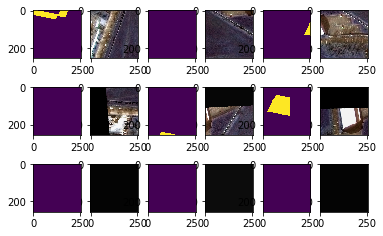

In [46]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
    plt.imshow(y[i-1])
#     plt.imshow(to_np(learn.model(V(x[i-1][None]))).squeeze())

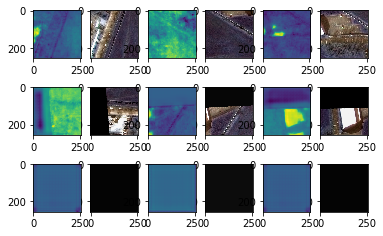

In [47]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
#     plt.imshow(y[i-1])
    pred = to_np(learn.model(V(x[i-1][None]))).squeeze()
#     pred = np.clip(pred, 0, 1)
    plt.imshow(pred)

In [66]:
device_ids=list(range(9))
net = to_gpu(UNet16(pretrained='vgg'))
net = nn.DataParallel(net, device_ids)
models = UpsampleModel(net)

In [71]:
x, y = md.trn_dl.get_batch(list(range(100)))

In [ ]:
for i in range(1, 9):
    device_ids=list(range(i))
    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    print(device_ids)
    %time for i in range(5): t = to_np(models.model(V(x).cuda())).squeeze(); np.max(t) - np.min(t)

[0]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

[0, 1]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/THCTensorCopy.cu:204

In [ ]:
learn.load('freeze_to_1_1')

In [ ]:
lr = 1e-4

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/50,lr])/2

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('unfreezed_1')

In [ ]:
learn.load('unfreezed_1')

In [ ]:
lrs = np.array([lr/3,lr]) / 5

In [ ]:
x, y = md.trn_dl.get_batch([o for o in range(9)])

In [ ]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
    plt.imshow(y[i-1])
#     plt.imshow(to_np(learn.model(V(x[i-1][None]))).squeeze())

In [ ]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
#     plt.imshow(y[i-1])
    pred = to_np(learn.model(V(x[i-1][None]))).squeeze()
#     pred = np.clip(pred, 0, 1)
    plt.imshow(pred)

In [ ]:
t = to_np(learn.model(V(x[1-1][None]))).squeeze()
ma = np.max(t)
mi = np.min(t)
ta = (t - mi) / (ma - mi)
print(ta)

In [ ]:
plt.imshow(denorm(x[1-1])[0])

In [ ]:
plt.imshow(t>0.5)

In [ ]:
smooth = 1e-12
intersection = torch.sum(y_true * y_pred)
sum_ = torch.sum(y_true + y_pred)
jac = (intersection + smooth) / (sum_ - intersection + smooth)
print(jac)

## Ditched experiments

In [ ]:
# # rgb scaled
# def get_rgb_scaled(datapath):
#     area_id = directory_name_to_area_id(datapath)
#     prefix = area_id_to_prefix(area_id)
    
#     X_val = []
#     fn_im = FMT_VALTEST_IM_STORE.format(prefix)
#     with tb.open_file(fn_im, 'r') as f:
#         for idx, image_id in enumerate(df_test.ImageId.tolist()):
#             im = np.array(f.get_node('/' + image_id))
#             im = np.swapaxes(im, 0, 2)
#             im = np.swapaxes(im, 1, 2)
#             X_val.append(im)
#     X_val = np.array(X_val)

#     y_val = []
#     fn_mask = FMT_VALTEST_MASK_STORE.format(prefix)
#     with tb.open_file(fn_mask, 'r') as f:
#         for idx, image_id in enumerate(df_test.ImageId.tolist()):
#             mask = np.array(f.get_node('/' + image_id))
#             mask = (mask > 0.5).astype(np.uint8)
#             y_val.append(mask)
#     y_val = np.array(y_val)
#     y_val = y_val.reshape((-1, 1, INPUT_SIZE, INPUT_SIZE))
#     return X_val, y_val

In [ ]:
# (trn_x,trn_y), (val_x,val_y) = get_dataset(datapath)

In [ ]:
def merge_file_list():
    df = pd.DataFrame()
    # clear file
    df.to_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
    for datapath in datapaths:
        area_id = directory_name_to_area_id(datapath)        
        prefix = area_id_to_prefix(area_id)
        fn_train = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
        df_train = pd.read_csv(fn_train)
#         fn_a = FMT_VALTRAIN_IMAGELIST_PATH_ALL
#         fn_im = FMT_VALTRAIN_MUL_STORE.format(prefix)
        fn_test = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix)
        df_test = pd.read_csv(fn_test)
        df = df.append(df_train).append(df_test)
        
    df.to_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
        

In [ ]:
import traceback
def merge_im(rgb=False):
    if rgb:
        fn_store_w = FMT_VALTRAIN_IM_STORE_ALL
    else:
        fn_store_w = FMT_VALTRAIN_MUL_STORE_ALL
        
    with tb.open_file(fn_store_w, 'w') as fw:
        for datapath in datapaths:
            try:
                area_id = directory_name_to_area_id(datapath)        
                prefix = area_id_to_prefix(area_id)

                # valtrain + valtest
                for (fn_store, fn_list) in [(FMT_VALTRAIN_MUL_STORE.format(prefix), FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)),
                                         (FMT_VALTEST_MUL_STORE.format(prefix), FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix))]:
                    df_list = pd.read_csv(fn_list, index_col='ImageId')
                    with tb.open_file(fn_store, 'r') as fr:
                        for idx, image_id in tqdm.tqdm(enumerate(df_list.index), total=df_list.shape[0]):
                            for slice_pos in range(9):
                                slice_id = image_id + '_' + str(slice_pos)
                                im = np.array(fr.get_node('/' + slice_id))
                                im = np.swapaxes(im, 0, 2)
                                im = np.swapaxes(im, 1, 2)
                                if rgb:
                                    im = im[:3,...]
                                atom = tb.Atom.from_dtype(im.dtype)
                                filters = tb.Filters(complib='blosc', complevel=9)
                                ds = fw.create_carray(fw.root, slice_id, atom, im.shape,
                                                     filters=filters)
                                ds[:] = im
            except Exception as e:
                traceback.print_exc()
                print(datapath, e)

In [ ]:
# merge_file_list()
# df = pd.read_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
# df.head()

In [ ]:
# merge_im(True)
# merge_im(False) # Too big

In [ ]:
# class ArraysSingleDataset(ArraysDataset):
#     def get_c(self): return 1
#     def denorm(self, arr):
#         """Reverse the normalization done to a batch of images.

#         Arguments:
#             arr: of shape/size (N,3,sz,sz)
#         """
#         if type(arr) is not np.ndarray: arr = to_np(arr)
#         if len(arr.shape)==3: arr = arr[None]
# #         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
#         return self.transform.denorm(np.rollaxis(arr,1,4))